# COMP90051 Project 2

**Copyright statement:** This notebook is copyright University of Melbourne. 
It is licensed for the sole purpose of your assessment in COMP90051. 
You are not permitted to share or publish derived versions of this notebook, other than with COMP90051 staff for assessment.

***

The code block below imports the namespaces/functions/classes you may use in the project. 
Additional imports are not permitted.

In [1]:
# Do not edit. These are the only imports permitted.
import numpy as np
from abc import ABC, abstractmethod

# Type annotations
from numpy import ndarray
from numpy.random import Generator
from typing import List, Deque, Optional, Tuple

from sklearn.cluster import KMeans                   # for Task 3
from sklearn.linear_model import LogisticRegression  # for Task 4
from collections import deque                        # for Task 5
from scipy.stats import multivariate_normal          # for Task 5
import matplotlib.pyplot as plt                      # for Task 6

The base `MAB` class below defines a common interface for a contextual multi-armed bandit. 
Your bandit implementations in Tasks 1-4 should inherit from this class.

In [2]:
class MAB(ABC):
    """Base class for a contextual multi-armed bandit (MAB)
    
    Parameters
    ----------
    n_arms : int
        Number of arms.
        
    rng : Generator, optional
        A `Generator` used as an internal source of randomness. If None, a 
        default `Generator` will be constructed using `np.random.default_rng`.
    """
    def __init__(self, n_arms: int, rng: Optional[Generator] = None) -> None:
        if not n_arms >= 0:
            raise ValueError("`n_arms` must be non-negative")
        self.n_arms = n_arms
        self.rng = np.random.default_rng(rng)
            
        
    @abstractmethod
    def play(self, context: ndarray) -> int:
        """Play a round
        
        Parameters
        ----------        
        context : float numpy.ndarray, shape (n_arms, n_dims), optional
            An array of context vectors presented to the MAB. The 0-th 
            axis indexes the arms, and the 1-st axis indexes the features.
            Non-contextual bandits accept a context of None.
        
        Returns
        -------
        arm : int
            Integer index of the arm played this round. Should be in the set 
            {0, ..., n_arms - 1}.
        """
        
    @abstractmethod
    def update(self, arm: int, context: ndarray, 
               reward: Optional[float] = None) -> None:
        """Update the internal state of the MAB after a play
        
        Parameters
        ----------
        arm : int
            Integer index of the played arm in the set {0, ..., n_arms - 1}.
        
        context : float numpy.ndarray, shape (n_arms, n_dims), optional
            An array of context vectors that was presented to the MAB. The 
            0-th axis indexes the arms, and the 1-st axis indexes the 
            features. Non-contextual bandits accept a context of None.
            
        reward : float, optional
            Reward received from the arm. If None, the reward is missing.
        """
        if arm >= self.n_arms or arm < 0:
            raise ValueError("`arm` must be in the range "
                             "[0, {}]".format(self.n_arms - 1))

The function below implements off-policy evaluation as described in Appendix A of the project spec. 
You should use it—along with the provided dataset—to evaluate the bandits in Tasks 1-4.

In [3]:
def offline_eval(mab: MAB, arms: ndarray, rewards: ndarray, contexts: ndarray, 
                 n_rounds: Optional[int] = None) -> ndarray:
    """Offline evaluation of a multi-armed bandit
    
    Parameters
    ----------
    mab : instance of MAB
        MAB to evaluate.
    
    arms : int ndarray, shape (n_events,) 
        Array containing the history of pulled arms, represented as integer 
        indices in the set {0, ..., mab.n_arms}
    
    rewards : float ndarray, shape (n_events,)
        Array containing the history of rewards. If a reward is missing, it 
        should be represented by `np.nan`.
    
    contexts : float ndarray, shape (n_events, n_arms, n_dims)
        Array containing the history of contexts presented to the arms. 
        The 0-th axis indexes the events in the history, the 1-st axis 
        indexes the arms and the 2-nd axis indexed the features.
        
    n_rounds : int, optional
        Number of matching events to evaluate the MAB on. If None, 
        continue evaluating until the historical events are exhausted.
    
    Returns
    -------
    matching_rewards : ndarray
        Rewards of matched events.
    
    matching_ids : ndarray
        Indices of matched events.
    """
    # Check types
    if not isinstance(mab, MAB):
        raise TypeError("`mab` must be an instance of MAB")
    arms = np.asarray(arms)
    rewards = np.asarray(rewards)
    contexts = np.asarray(contexts)
    if n_rounds is not None and n_rounds < 0:
        raise ValueError("`n_rounds` must be non-negative")
    
    # Check array dimensions
    if arms.ndim != 1:
        raise ValueError("`arms` must be a 1D array")
    if rewards.ndim != 1:
        raise ValueError("`rewards` must be a 1D array")
    if contexts.ndim != 3:
        raise ValueError("`contexts` must be a 3D array")
    if not (arms.shape[0] == rewards.shape[0] == contexts.shape[0]):
        raise ValueError("first dimension of input arrays are inconsistent")
    if contexts.shape[1] != mab.n_arms:
        raise ValueError("`contexts` has inconsistent second dimension")
    if arms.max() >= mab.n_arms or arms.min() < 0:
        raise ValueError("`arms` contains ids that are out-of-range")
    
    matched_ctr = 0
    matched_ids = list()
    for i in range(arms.size):
        if n_rounds is not None and matched_ctr >= n_rounds:
            break
        arm_id = mab.play(contexts[i])
        if arm_id == arms[i]:
            reward = None if np.isnan(rewards[i]) else rewards[i]
            mab.update(arm_id, contexts[i], reward)
            matched_ctr += 1
            matched_ids.append(i)
    
    matched_ids = np.array(matched_ids)
    return rewards[matched_ids], matched_ids

Please define any static functions/variables (used across multiple tasks) in the code block below.

In [4]:
rng = np.random.default_rng(90051)  # Random generator used throughout

N_ARMS = 10 # number of arms
N_DIMS = 10 # number of dimensions of each context
SEED = 90051  # common seed used throughout

## Task 1: Implement LinUCB

In [5]:
class LinUCB(MAB):
    """LinUCB

    Parameters
    ----------
    n_arms : int
        Number of arms.

    n_dims : int
        Number of features for each arm's context.

    alpha : float
        Positive real explore-exploit parameter.
    
    rng : Generator, optional
        A `Generator` used as an internal source of randomness. If None, a 
        default `Generator` will be constructed using `np.random.default_rng`.
    """
    def __init__(self, n_arms: int, n_dims: int, alpha: float, 
                 rng: Optional[Generator] = None) -> None:
        super().__init__(n_arms, rng)
        self.n_dims = n_dims
        self.alpha = alpha
        self.A = {}
        self.b = {}
        
        for i in range(n_arms):
            # initialise A and b for every arm to an identity matrix and 0 vector respectively
            self.A[f'a{i}'] = np.eye(self.n_dims)
            self.b[f'a{i}'] = np.zeros((self.n_dims, 1))
            
        
    def play(self, context: ndarray) -> int:
        
        # pt = UCB of the expected payoff/reward for all arms at trial t
        pt = np.zeros(self.n_arms)
        
        for i in range(self.n_arms):
            # for each arm calculate:
            # p = transpose(theta_hat) * x + alpha * sqrt(transpose(x) * A_inverse * x)
            # and store p in pt
            x = context[i, :].reshape(-1, 1) # context of the current arm
            A = self.A[f'a{i}']
            b = self.b[f'a{i}']
            A_inv = np.linalg.inv(A)    
            theta_hat = A_inv @ b  # estimated parameters of ridge regression
            expected_payoff = np.dot(theta_hat.T, x)
            sd = (np.dot(np.dot(x.T, A_inv), x))**0.5  # standard deviation of the expected payoff/reward
            p = expected_payoff + self.alpha*sd  # UCB of the expected payoff/reward
            pt[i] = p
            
        # at = arm with the maximum payoff/reward    
        at = np.argwhere(np.amax(pt)==pt).flatten()
        
        if at.size > 1:
            # randomly choose among multiple arms in case there are multiple arms with maximum payoff/reward 
            return self.rng.choice(at)
        else:
            return at[0]
                
            
    def update(self, arm: int, context: ndarray, 
               reward: Optional[float] = None) -> None:
        
        super().update(arm, context) 
        
        # update matrix A and vector b of the played arm if reward is not None:
        # A = A + x * transpose(x)
        # b = b + reward * x
        x = context[arm, :].reshape(-1, 1)
        if reward is not None:
            self.A[f'a{arm}'] = self.A[f'a{arm}'] + np.dot(x, x.T)
            self.b[f'a{arm}'] = self.b[f'a{arm}'] + reward*x
            

In [6]:
# load dataset
data = np.loadtxt('dataset.txt', dtype='float')

# column 1 : the arms played
# typecast float to int as required by offline_eval()
arms = data[:, 0].astype('int') 

# column 2 : the reward received for the arm played
rewards = data[:, 1]

# columns 4-103 : 10 features per arm for 10 arms
# reshape to (n_events, n_arms, n_dims) as required by offline_eval()
contexts = data[:, 3:].reshape(-1, N_ARMS, N_DIMS)

In [7]:
mab = LinUCB(10, 10, 1.0, rng)
LinUCB_rewards, _ = offline_eval(mab, arms, rewards, contexts, 800)
print('LinUCB average reward', np.mean(LinUCB_rewards))

LinUCB average reward 0.53


####################################### Experiment b #######################################

Plotting per-round cumulative reward


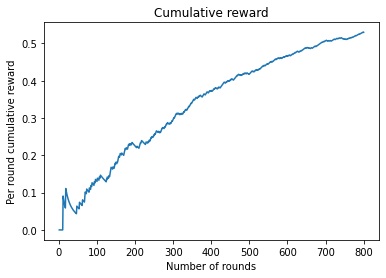

####################################### Experiment c #######################################

Tuning hyperparameter 'alpha'

Searching space of alpha for best average reward initially in (0, 10), since alpha > 0 and then narrowing down the search space around the best average reward sequentially
LinUCB average reward for alpha 0.0: 0.3926441351888668
LinUCB average reward for alpha 1.0: 0.5632530120481928
LinUCB average reward for alpha 2.0: 0.371875
LinUCB average reward for alpha 3.0: 0.2768762677484787
LinUCB average reward for alpha 4.0: 0.2231237322515213
LinUCB average reward for alpha 5.0: 0.1885245901639344
LinUCB average reward for alpha 6.0: 0.16288252714708787
LinUCB average reward for alpha 7.0: 0.14858260019550343
LinUCB average reward for alpha 8.0: 0.13431372549019607
LinUCB average reward for alpha 9.0: 0.12950340798442064
LinUCB average reward for alpha 10.0: 0.1197252208047105


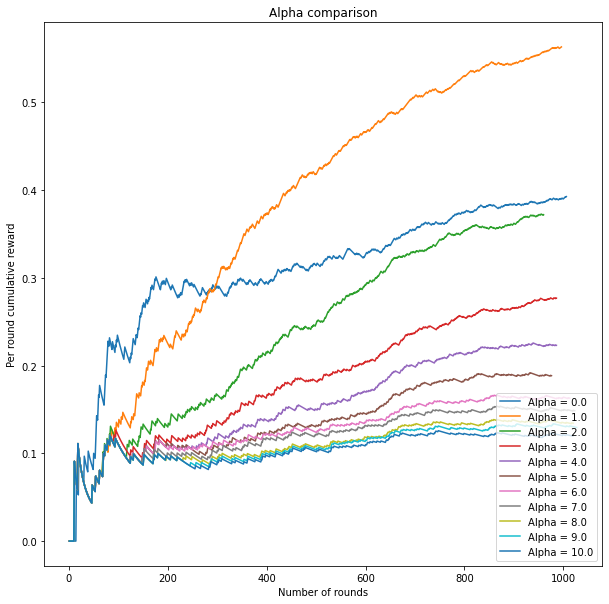


The best average reward for the previous search was at alpha = 1
Narrowing down the search space to around 1 : (0, 2)
LinUCB average reward for alpha 0.0: 0.5877551020408164
LinUCB average reward for alpha 0.1: 0.7264705882352941
LinUCB average reward for alpha 0.2: 0.6994106090373281
LinUCB average reward for alpha 0.30000000000000004: 0.669260700389105
LinUCB average reward for alpha 0.4: 0.6615236258437801
LinUCB average reward for alpha 0.5: 0.6514399205561072
LinUCB average reward for alpha 0.6000000000000001: 0.6295928500496525
LinUCB average reward for alpha 0.7000000000000001: 0.6053412462908012
LinUCB average reward for alpha 0.8: 0.5877106045589693
LinUCB average reward for alpha 0.9: 0.5678137651821862
LinUCB average reward for alpha 1.0: 0.5632530120481928
LinUCB average reward for alpha 1.1: 0.539
LinUCB average reward for alpha 1.2000000000000002: 0.5236220472440944
LinUCB average reward for alpha 1.3: 0.5014866204162537
LinUCB average reward for alpha 1.4000000000000001

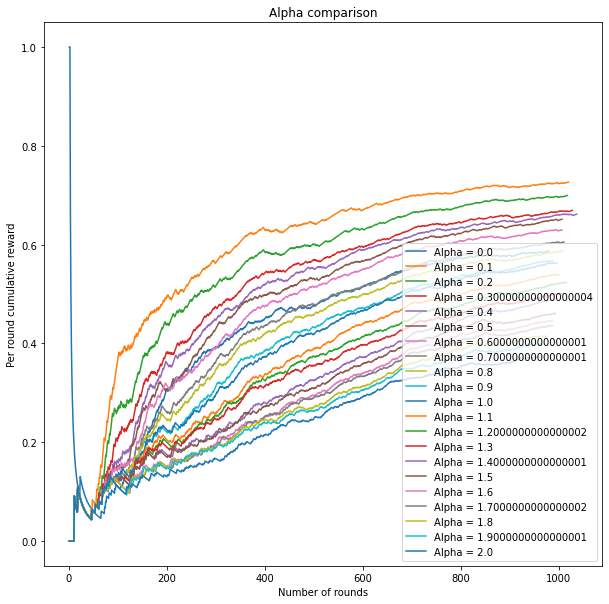


The best average reward for the previous search was at alpha = 0.1
Narrowing down the search space to around 0.1 : (0, 0.2)
LinUCB average reward for alpha 0.0: 0.6503067484662577
LinUCB average reward for alpha 0.01: 0.7451171875
LinUCB average reward for alpha 0.02: 0.7441176470588236
LinUCB average reward for alpha 0.03: 0.7366863905325444
LinUCB average reward for alpha 0.04: 0.728515625
LinUCB average reward for alpha 0.05: 0.735609756097561
LinUCB average reward for alpha 0.06: 0.7297560975609756
LinUCB average reward for alpha 0.07: 0.7216796875
LinUCB average reward for alpha 0.08: 0.7260138476755688
LinUCB average reward for alpha 0.09: 0.7241715399610137
LinUCB average reward for alpha 0.1: 0.7264705882352941
LinUCB average reward for alpha 0.11: 0.7202323330106486
LinUCB average reward for alpha 0.12: 0.7151277013752456
LinUCB average reward for alpha 0.13: 0.7163601161665053
LinUCB average reward for alpha 0.14: 0.7170731707317073
LinUCB average reward for alpha 0.15: 0.72

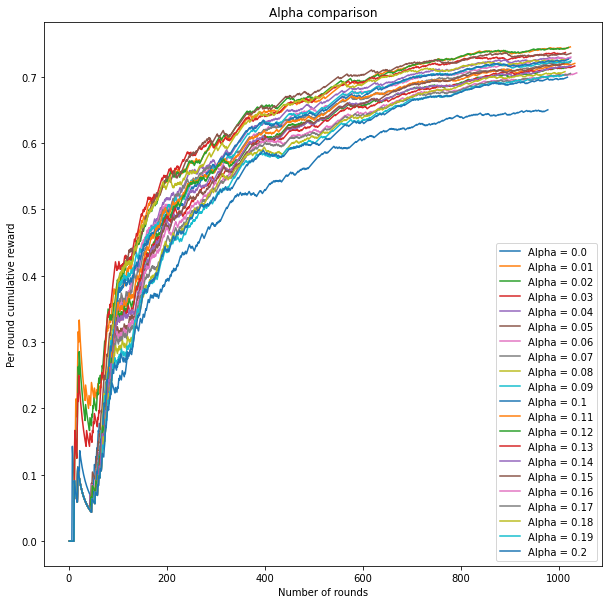


The best average reward for the previous search was at alpha = 0.01
Narrowing down the search space to around 0.01 : (0, 0.02)
LinUCB average reward for alpha 0.0: 0.6812313803376365
LinUCB average reward for alpha 0.001: 0.7247706422018348
LinUCB average reward for alpha 0.002: 0.7333994053518335
LinUCB average reward for alpha 0.003: 0.744466800804829
LinUCB average reward for alpha 0.004: 0.7455089820359282
LinUCB average reward for alpha 0.005: 0.6514522821576764
LinUCB average reward for alpha 0.006: 0.6567926455566905
LinUCB average reward for alpha 0.007: 0.6601842374616171
LinUCB average reward for alpha 0.008: 0.7345739471106758
LinUCB average reward for alpha 0.009000000000000001: 0.7429130009775171
LinUCB average reward for alpha 0.01: 0.7451171875
LinUCB average reward for alpha 0.011: 0.74609375
LinUCB average reward for alpha 0.012: 0.7403100775193798
LinUCB average reward for alpha 0.013000000000000001: 0.7383720930232558
LinUCB average reward for alpha 0.014: 0.7514792

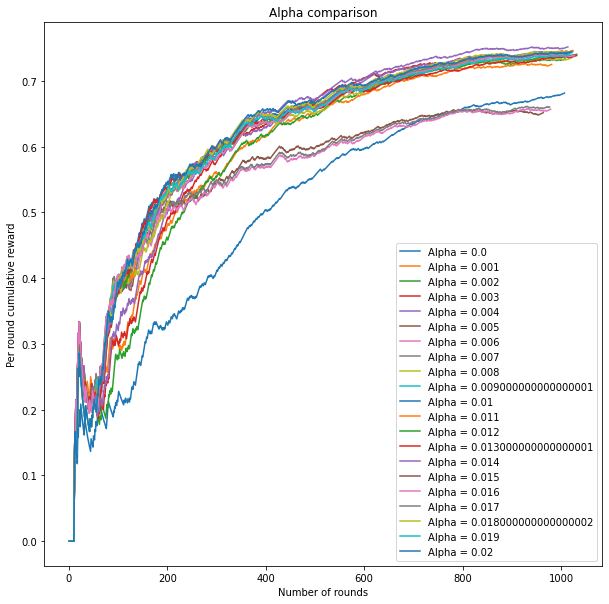


The best average reward for the previous search was at alpha = 0.014
Narrowing down the search space to around 0.014 : (0.013, 0.015)
LinUCB average reward for alpha 0.013: 0.7383720930232558
LinUCB average reward for alpha 0.013099999999999999: 0.7405247813411079
LinUCB average reward for alpha 0.0132: 0.7405247813411079
LinUCB average reward for alpha 0.0133: 0.7522211253701876
LinUCB average reward for alpha 0.013399999999999999: 0.7522211253701876
LinUCB average reward for alpha 0.0135: 0.7522211253701876
LinUCB average reward for alpha 0.0136: 0.7529644268774703
LinUCB average reward for alpha 0.013699999999999999: 0.7529644268774703
LinUCB average reward for alpha 0.0138: 0.7529644268774703
LinUCB average reward for alpha 0.0139: 0.7514792899408284
LinUCB average reward for alpha 0.013999999999999999: 0.7514792899408284
LinUCB average reward for alpha 0.0141: 0.7514792899408284
LinUCB average reward for alpha 0.014199999999999999: 0.7514792899408284
LinUCB average reward for alp

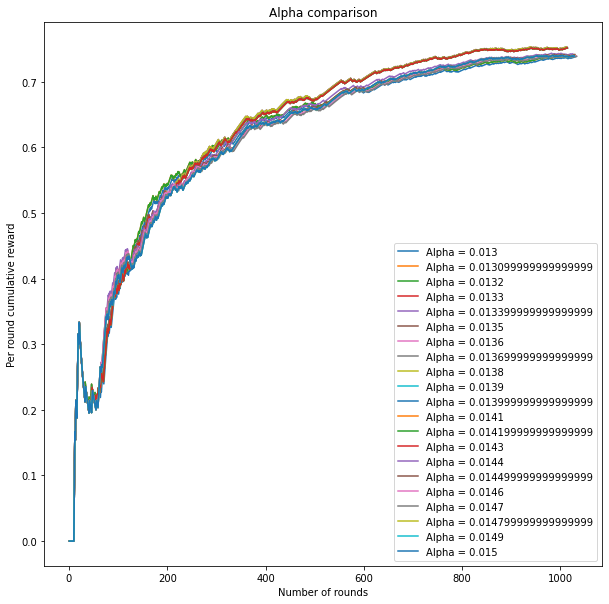


As we can observe from the graph, the average rewards have started to converge at this level
Therefore, the optimal value of alpha belongs in (0.013, 0.015)


In [8]:
# Use additional cells here for experimentation

print("####################################### Experiment b #######################################")
print("\nPlotting per-round cumulative reward")

def plot_cumulative_reward_LinUCB(cum_rewards_per_round, n_rounds):
    """
    This function plots average cumulative reward per round for a fixed alpha
    
    Parameters
    ------------------------------------------------------
    cum_rewards_per_round : float ndarray, shape (n_rounds,)
        array of average cumulative reward per round
        
    n_rounds : int
        number of rounds
    ------------------------------------------------------
    """
    n_rounds_range = range(1, n_rounds+1)
    plt.plot(n_rounds_range, cum_rewards_per_round)
    plt.title('Cumulative reward')
    plt.ylabel('Per round cumulative reward')
    plt.xlabel('Number of rounds')
    plt.show()
    
n_rounds = LinUCB_rewards.shape[0]
cum_rewards = np.cumsum(LinUCB_rewards) # cumulative reward
cum_rewards_per_round = cum_rewards/np.arange(1, n_rounds + 1) # average cumulative reward
plot_cumulative_reward_LinUCB(cum_rewards_per_round, n_rounds)

print("####################################### Experiment c #######################################")
print("\nTuning hyperparameter 'alpha'")

def plot_alpha_comparison(results):
    """
    This function plots average cumulative reward per round for various alphas
    
    Parameter
    -----------------------
    results : list
        List of dictonaries where each dictionary has two keys: 'alpha', an alpha value and
        'cum_rewards_per_round', average cumulative reward per round for that alpha
    -----------------------
    """
    legends = []
    plt.figure(figsize=(10, 10))
    for i in results:
        plt.plot(range(1, i['cum_rewards_per_round'].size + 1), i['cum_rewards_per_round'])
        legends.append(f'Alpha = {i["alpha"]}')
    plt.title('Alpha comparison')
    plt.ylabel('Per round cumulative reward')
    plt.xlabel('Number of rounds')
    plt.legend(legends, loc='lower right')
    plt.show()
    
def tune_hyperparameter_LinUCB(alphas):
    """
    This function take the search space of alpha as input and returns
    the best alpha and its corresponding average reward and also 
    average cumulative reward per round for every alpha
    
    Parameter
    ---------------------
    alpha : float ndarray
        Evenly-spaced values of alpha in a partiular interval
    ---------------------
    
    Returns
    ---------------------
    max_mean_reward : dict
        A dictonary with two keys: 'alpha', the best alpha in this particular search space 
        and the corresponding mean reward, 'mean_reward'
        
    results : list
        List of dictonaries where each dictionary has two keys: 'alpha', an alpha value and
        'cum_rewards_per_round', average cumulative reward per round
    ---------------------
    """
    results = []
    max_mean_reward = None

    for alpha in alphas:
        mab1 = LinUCB(10, 10, alpha, rng)
        LinUCB_rewards1, _ = offline_eval(mab1, arms, rewards, contexts)  # number of rounds is not passed to indicate exhaustive search over the entire history
        n_rounds = LinUCB_rewards1.size  # update number of rounds for this alpha with the returned reward array size
        mean_reward = np.mean(LinUCB_rewards1)
        
        # store the optimal mean reward and the corresponding alpha
        if max_mean_reward is None or mean_reward > max_mean_reward['mean_reward']:
            max_mean_reward = {'mean_reward': mean_reward, 'alpha': alpha}
            
        print(f'LinUCB average reward for alpha {alpha}:', mean_reward)
        cum_rewards = np.cumsum(LinUCB_rewards1)
        cum_rewards_per_round = cum_rewards/np.arange(1, n_rounds + 1)
        results.append({'cum_rewards_per_round': cum_rewards_per_round, 'alpha': alpha})
    
    plot_alpha_comparison(results)
    
    return max_mean_reward, results

print("\nSearching space of alpha for best average reward initially in (0, 10), since alpha > 0 and then narrowing down the search space around the best average reward sequentially")
max_mean_reward, history = tune_hyperparameter_LinUCB(np.linspace(0, 10, 11))

print("\nThe best average reward for the previous search was at alpha = 1\nNarrowing down the search space to around 1 : (0, 2)")
max_mean_reward, history = tune_hyperparameter_LinUCB(np.linspace(0, 2, 21))

print("\nThe best average reward for the previous search was at alpha = 0.1\nNarrowing down the search space to around 0.1 : (0, 0.2)")
max_mean_reward, history = tune_hyperparameter_LinUCB(np.linspace(0, 0.2, 21))

print("\nThe best average reward for the previous search was at alpha = 0.01\nNarrowing down the search space to around 0.01 : (0, 0.02)")
max_mean_reward, history = tune_hyperparameter_LinUCB(np.linspace(0, 0.02, 21))

print("\nThe best average reward for the previous search was at alpha = 0.014\nNarrowing down the search space to around 0.014 : (0.013, 0.015)")
max_mean_reward, history = tune_hyperparameter_LinUCB(np.linspace(0.013, 0.015, 21))

print("\nAs we can observe from the graph, the average rewards have started to converge at this level\nTherefore, the optimal value of alpha belongs in (0.013, 0.015)")

## Task 2: Implement MLinUCB

In [9]:
class MLinUCB(LinUCB):
    """MLinUCB

    Parameters
    ----------
    n_arms : int
        Number of arms.

    n_dims : int
        Number of features for each arm's context.

    alpha : float
        Positive real explore-exploit parameter.
    
    N : int
        Number of clusters
        
    m : int
        Number of closest clusters to use when imputing the reward.
    
    rng : Generator, optional
        A `Generator` used as an internal source of randomness. If None, a 
        default `Generator` will be constructed using `np.random.default_rng`.
    """
    def __init__(self, n_arms: int, n_dims: int, alpha: float, N: int, m: int, 
                 rng: Optional[Generator] = None) -> None:
        super().__init__(n_arms, n_dims, alpha, rng)
        self.N = N
        self.m = m
        self.contexts = None  # stores history of context vectors till trial t
        self.kmeans = None  # stores the KMeans model
        self.rewards = None  # stores history of rewards till trial t
        
    
    def update_cluster(self, context: ndarray, reward: float) -> None:
        """
        This function updates the cluster with the new context and 
        updates the reward history with the new reward
        
        Parameters
        ------------------------
        context: float ndarray, shape (n_dims, )
            The new context to update the cluster with
            
        reward: float
            The reward associated with the new context
        ------------------------
        """
        # update history of contexts
        if self.contexts is None:
            self.contexts = context.reshape(1, -1)
        else:
            self.contexts = np.vstack((self.contexts, context.reshape(1, -1)))
        # update history of rewards
        if self.rewards is None:
            self.rewards = np.array([reward])
        else:
            self.rewards = np.append(self.rewards, reward)
        # update cluster
        n_clusters = min(self.N, self.contexts.shape[0])
        self.kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(self.contexts)
        
    
    def find_m_nearest_clusters(self, context):
        """
        This function returns the m nearest clusters (m least distances)
        to the given context
        
        Parameters
        ------------------------
        context: float ndarray, shape (n_dims, )
            The new context to update the cluster with
        ------------------------
        
        Returns
        ------------------------
        m: int
            Number of nearest clusters considered
            
        m_nearest_clusters: int ndarray, shape (m,)
            Indices of the m nearest clusters to the given context 
        
        distances[m_nearest_clusters]: float ndarray, shape (m,)
            Distances of the m nearest clusters to the given context
        ------------------------
        """
        m = min(self.m, self.contexts.shape[0])
        distances = self.kmeans.transform(context.reshape(1, -1)).flatten()  # distance of this context vector to all the clusters
        m_nearest_clusters = np.argsort(distances)[:m]  # index of m nearest clusters according to distances
        return m_nearest_clusters, distances[m_nearest_clusters], m
    
    
    def calculate_average_reward_for_clusters(self, clusters):
        """
        This functions returns average reward per cluster
        
        Parameters
        ------------------------
        clusters: int ndarray, shape (m,)
            Indices of the clusters to calculate the average reward for
        ------------------------
        
        Returns 
        ------------------------
        np.array(average_rewards): float ndarray, shape (clusters.size,)
            An array of average rewards, one entry per cluster
        ------------------------
        """
        average_rewards = []  # stores average reward for m nearest clusters
        for cluster in clusters:
            count = np.sum(self.kmeans.labels_ == cluster)  # count of data points in this cluster
            total_reward = np.sum(self.rewards[self.kmeans.labels_ == cluster], axis=0)  # total reward for this cluster
            average_rewards.append(total_reward/count)  # store average reward for this cluster
        return np.array(average_rewards)
    
        
    def calculate_reward(self, average_rewards, distances):
        """
        This function returns weighted average of the average cluster rewards
        """
        if not (average_rewards.shape[0] == distances.shape[0]):
            raise ValueError("dimensions of input arrays are inconsistent")
        else:
            return np.sum(average_rewards/(0.1 + distances))/np.sum(1/(0.1 + distances))
        
        
    def play(self, context: ndarray) -> int:
        return super().play(context)
    
    
    def update(self, arm: int, context: ndarray, 
               reward: Optional[float] = None) -> None:
        r = reward
        s = 0 if self.contexts is None else self.contexts.shape[0]  # number of samples in the cluster
        if reward is None and s > 0:
            m_nearest_clusters, m_nearest_cluster_distances, m = self.find_m_nearest_clusters(context[arm, :])
            average_reward_for_clusters = self.calculate_average_reward_for_clusters(m_nearest_clusters)
            r = self.calculate_reward(average_reward_for_clusters, m_nearest_cluster_distances)   

        if reward is not None:
        # only update cluster for the available rewards (not calculated rewards)
            self.update_cluster(context[arm, :], reward)
            
        if s > 0 or r is not None:   
        # update the paramters when there are more than one samples in the cluster and 
        # when the reward is available (original or calculated)
            super().update(arm, context, r)

In [10]:
# column 3 : This indicator value says whether the reward should be missing (1) or available (0)
missing_rewards = data[:, 2]

# Define rewards_missing here - the rewards array from above where missing values are represented as np.nan
rewards_missing = np.where(missing_rewards, np.nan, rewards)

In [11]:
mab1 = MLinUCB(10, 10, 1.0, 10, 3, rng)
MLinUCB_rewards, MLinUCB_ids = offline_eval(mab1, arms, rewards_missing, contexts, 800)
print('MLinUCB average reward', np.mean(rewards[MLinUCB_ids]))

mab2 = LinUCB(10, 10, 1.0, rng)
LinUCB_rewards, LinUCB_ids = offline_eval(mab2, arms, rewards_missing, contexts, 800)
print('LinUCB average reward', np.mean(rewards[LinUCB_ids]))

MLinUCB average reward 0.365
LinUCB average reward 0.37875


####################################### Experiment b #######################################

Plotting comparison of per-round cumulative reward for LinUCB and MLinUCB


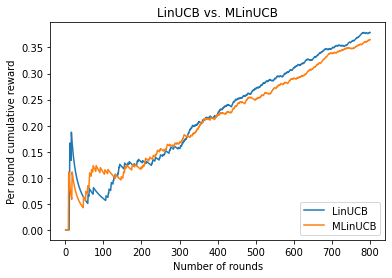

####################################### Experiment c #######################################

Tuning hyperparameters 'N', 'm' and 'alpha'

Search space of alpha is motivated by the best alpha found for LinUCB

MLinUCB average reward for alpha = 0.01, N = 5, m = 1: 0.2925
MLinUCB average reward for alpha = 0.01, N = 5, m = 3: 0.42875
MLinUCB average reward for alpha = 0.01, N = 5, m = 5: 0.41875
Best m for N=5 is 3 with mean reward 0.42875
MLinUCB average reward for alpha = 0.01, N = 10, m = 1: 0.47375
MLinUCB average reward for alpha = 0.01, N = 10, m = 3: 0.225
MLinUCB average reward for alpha = 0.01, N = 10, m = 5: 0.38125
MLinUCB average reward for alpha = 0.01, N = 10, m = 7: 0.47625
MLinUCB average reward for alpha = 0.01, N = 10, m = 9: 0.425
Best m for N=10 is 7 with mean reward 0.47625
MLinUCB average reward for alpha = 0.01, N = 15, m = 1: 0.3925
MLinUCB average reward for alpha = 0.01, N = 15, m = 3: 0.48
MLinUCB average reward for alpha = 0.01, N = 15, m = 5: 0.28375
MLinUCB

MLinUCB average reward for alpha = 0.02, N = 35, m = 1: 0.4625
MLinUCB average reward for alpha = 0.02, N = 35, m = 3: 0.52375
MLinUCB average reward for alpha = 0.02, N = 35, m = 5: 0.32375
MLinUCB average reward for alpha = 0.02, N = 35, m = 7: 0.3275
MLinUCB average reward for alpha = 0.02, N = 35, m = 9: 0.31875
MLinUCB average reward for alpha = 0.02, N = 35, m = 11: 0.47
MLinUCB average reward for alpha = 0.02, N = 35, m = 13: 0.48
MLinUCB average reward for alpha = 0.02, N = 35, m = 15: 0.49625
MLinUCB average reward for alpha = 0.02, N = 35, m = 17: 0.45125
MLinUCB average reward for alpha = 0.02, N = 35, m = 19: 0.4625
Best m for N=35 is 3 with mean reward 0.52375
MLinUCB average reward for alpha = 0.02, N = 40, m = 1: 0.58375
MLinUCB average reward for alpha = 0.02, N = 40, m = 3: 0.555
MLinUCB average reward for alpha = 0.02, N = 40, m = 5: 0.3375
MLinUCB average reward for alpha = 0.02, N = 40, m = 7: 0.49125
MLinUCB average reward for alpha = 0.02, N = 40, m = 9: 0.47625
M

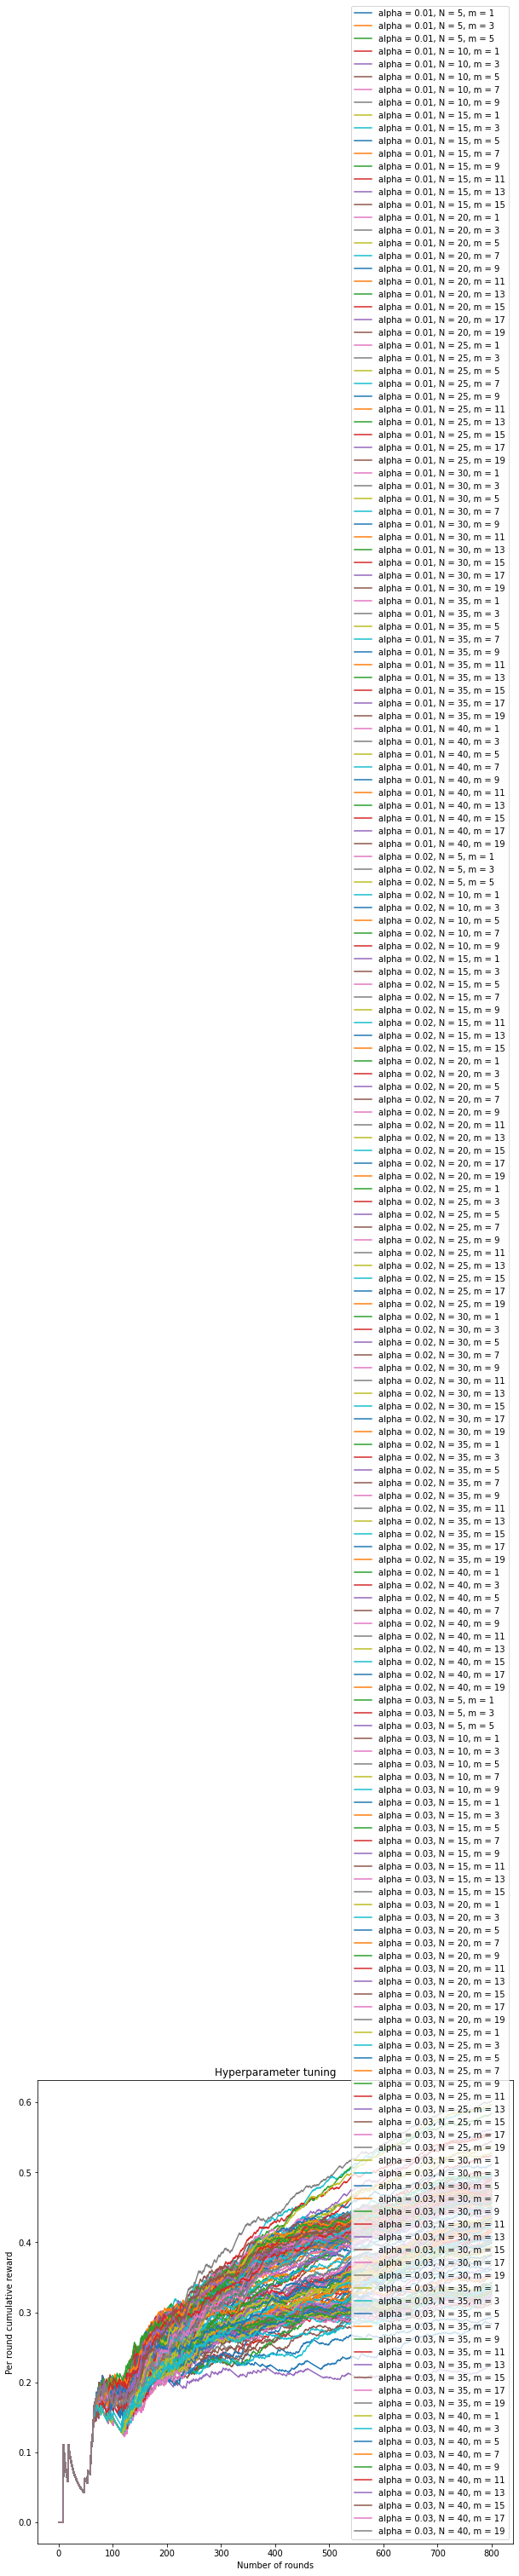

In [12]:
# Use additional cells here for experimentation

print("####################################### Experiment b #######################################")
print("\nPlotting comparison of per-round cumulative reward for LinUCB and MLinUCB")

def bandit_comparison_plots(results, n_rounds):
    """
    This function plots average cumulative reward per round 
    comparing 2 different MABs
    
    Parameters
    ------------------------------------------------------
    results : list  
        a list of dict having 2 keys: 
        'type' - 'LinUCB'/'MLinUCB'
        'cum_rewards_per_round' - ndarray of average cumulative reward per round of shape (n_rounds,)
        
    n_rounds : int
        number of rounds
    ------------------------------------------------------
    """
    n_rounds_range = range(1, n_rounds+1)
    legends = []
    for bandit in results:
        plt.plot(n_rounds_range, bandit['cum_rewards_per_round'])
        legends.append(f'{bandit["type"]}')
    plt.title(f'{results[0]["type"]} vs. {results[1]["type"]}')
    plt.ylabel('Per round cumulative reward')
    plt.xlabel('Number of rounds')
    plt.legend(legends, loc='lower right')
    plt.show()
    
n_rounds = 800
results = [{
    'type': 'LinUCB',
    'cum_rewards_per_round': np.cumsum(rewards[LinUCB_ids])/np.arange(1, n_rounds + 1)
}, {
    'type': 'MLinUCB',
    'cum_rewards_per_round': np.cumsum(rewards[MLinUCB_ids])/np.arange(1, n_rounds + 1)
}]
    
bandit_comparison_plots(results, n_rounds)


print("####################################### Experiment c #######################################")
print("\nTuning hyperparameters 'N', 'm' and 'alpha'")

def plot_comparison2(results, n_rounds):
    """
    This function plots average cumulative reward per round 
    comparing different hyperparameters
    
    Parameters
    ------------------------------------------------------
    results : list  
        a list of dict having 2 keys:
        'cum_rewards_per_round' - ndarray of average cumulative reward per round of shape (n_rounds,)
        'params' - string to appear as a legend in the graph
        
    n_rounds : int
        number of rounds
    ------------------------------------------------------
    """
    n_rounds_range = range(1, n_rounds+1)
    legends = []
    plt.figure(figsize=(10, 10))
    for i in results:
        plt.plot(n_rounds_range, i['cum_rewards_per_round'])
        legends.append(f'{i["params"]}')
    plt.title('Hyperparameter tuning')
    plt.ylabel('Per round cumulative reward')
    plt.xlabel('Number of rounds')
    plt.legend(legends, loc='lower right')
    plt.show()

print("\nSearch space of alpha is motivated by the best alpha found for LinUCB\n")

results = []
n_rounds = 800

best_alpha = {'alpha': None, 'N': None, 'm': None, 'reward': None}

for alpha in np.arange(0.01, 0.04, 0.01):
    best_N = {'N': None, 'm': None, 'reward': None}
    
    for number_of_clusters in np.arange(5, 41, 5):
        best_m = {'m': None, 'reward': None}
        
        for m_nearest_clusters in np.arange(1, min(20, number_of_clusters + 1), 2):
            
            mab1 = MLinUCB(10, 10, alpha, number_of_clusters, m_nearest_clusters, rng)
            MLinUCB_rewards1, MLinUCB_ids1 = offline_eval(mab1, arms, rewards_missing, contexts, n_rounds)
            mean_reward = np.mean(rewards[MLinUCB_ids1])
            
            # record the optimal m 
            if best_m['m'] is None or mean_reward > best_m['reward']:
                best_m['m'] = m_nearest_clusters
                best_m['reward'] = mean_reward
                
            print(f'MLinUCB average reward for alpha = {alpha}, N = {number_of_clusters}, m = {m_nearest_clusters}:', mean_reward)
            cum_rewards = np.cumsum(rewards[MLinUCB_ids1])
            cum_rewards_per_round = cum_rewards/np.arange(1, n_rounds + 1)
            results.append({'cum_rewards_per_round': cum_rewards_per_round, 'params': f'alpha = {alpha}, N = {number_of_clusters}, m = {m_nearest_clusters}'})
        
        print(f"Best m for N={number_of_clusters} is {best_m['m']} with mean reward {best_m['reward']}")
        
        # record the optimal N
        if best_N['N'] is None or best_m['reward'] > best_N['reward']:
            best_N['N'] = number_of_clusters
            best_N['reward'] = best_m['reward']
            best_N['m'] = best_m['m']
    
    print("=================================================================================================")
    print(f"Best N for alpha = {alpha} is {best_N['N']} with m = {best_N['m']}, mean reward {best_N['reward']}")
    print("=================================================================================================")
    
    # record the optimal alpha
    if best_alpha['alpha'] is None or best_N['reward'] > best_alpha['reward']:
        best_alpha['alpha'] = alpha
        best_alpha['N'] = best_N['N']
        best_alpha['m'] = best_N['m']
        best_alpha['reward'] = best_N['reward']
        
print("xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx")
print(f"Best reward is {best_alpha['reward']} for alpha = {best_alpha['alpha']}, N = {best_alpha['N']}, m = {best_alpha['m']}")
print("xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx")

plot_comparison2(results, n_rounds)

## Task 3: Implement SquareCB

In [13]:
class SquareCB(MAB):
    """SquareCB with a logistic regression oracle

    Parameters
    ----------
    n_arms : int
        Number of arms.

    n_dims : int
        Number of features for each arm's context.
    
    gamma : float
        Learning rate parameter.
    
    rng : Generator, optional
        A `Generator` used as an internal source of randomness. If None, a 
        default `Generator` will be constructed using `np.random.default_rng`.
    """
    def __init__(self, n_arms: int, n_dims: int, gamma: float, 
                 rng: Optional[Generator] = None) -> None:
        super().__init__(n_arms, rng)
        self.rng = np.random.default_rng(SEED)
        self.n_dims = n_dims
        self.gamma = gamma
        self.mu = n_arms  # hard-coding parameter 'mu' of SquareCB to number of arms
        self.oracles = {}  # stores oracle for every arm
        self.contexts = {}  # stores history of context vectors till trial t
        self.rewards = {}  # stores history of rewards till trial t
        
        # initialise oracle, context history, reward history for every arm with None
        for arm in range(n_arms):
            self.oracles[f'arm{arm}'] = None
            self.contexts[f'arm{arm}'] = None
            self.rewards[f'arm{arm}'] = None
            
    
    def play(self, context: ndarray) -> int:
        b = None  # stores index of arm with minimum predicted loss
        y_hat = np.zeros(self.n_arms)  # stores predicted losses for all arms
        
        if not all(self.oracles.values()):
        # choose an arm randomly if model for any arm is not available
            return self.rng.choice(np.arange(self.n_arms))
        else:
            for arm in range(self.n_arms):
                y_train = self.rewards[f'arm{arm}']  # history of rewards for this arm
                y_hat_a = None
                
                if np.all(y_train==y_train[0]):
                # set y_h_a to the common loss if all the losses are the same
                # (this solution gives better result than 'selecting arm uniformly at random')
                    y_hat_a = -y_train[0]
                else:
                # else predict the loss
                # (predict() gives better result than predict_proba())
                    y_hat_a = self.oracles[f'arm{arm}'].predict(context[arm, :].reshape(1, -1))
                
                y_hat[arm] = y_hat_a
                
            # b = arm with the minimum predicted loss    
            b = np.argwhere(np.amin(y_hat)==y_hat).flatten()
            if b.size > 1:
            # randomly choose among multiple arms in case there are multiple arms with minimum loss 
                b = self.rng.choice(b)
            else:
                b = b[0]
                
        p_t = np.zeros(self.n_arms)  # stores probability distribution for arms
        # probability for every arm except arm b (arm with minimum predicted loss)
        for arm in range(self.n_arms):
            if arm != b:
                p_t[arm] = 1/(self.mu + self.gamma*(y_hat[arm] - y_hat[b]))
        # probability of arm b = 1 - sum of probabilties of all the other arms
        p_t[b] = 1 - np.sum(np.array(p_t))

        return self.rng.choice(np.arange(self.n_arms), p=p_t)  # sample an arm from the probability distribution
    
    
    def update(self, arm: int, context: ndarray, 
               reward: Optional[float] = None) -> None:
        
        # update context
        if self.contexts[f'arm{arm}'] is None:
            self.contexts[f'arm{arm}'] = context[arm, :].reshape(1, -1)
        else:
            self.contexts[f'arm{arm}'] = np.vstack((self.contexts[f'arm{arm}'], context[arm, :].reshape(1, -1)))
            
        # update reward
        if self.rewards[f'arm{arm}'] is None:
                self.rewards[f'arm{arm}'] = np.array([reward])
        else:
            self.rewards[f'arm{arm}'] = np.append(self.rewards[f'arm{arm}'], reward)
            
        #update oracle
        X = self.contexts[f'arm{arm}']
        y = self.rewards[f'arm{arm}']
        if not np.all(y==y[0]):
        # fit history of contexts to orcale of the selected arm only when all the rewards for that arm are not same
            self.oracles[f'arm{arm}'] = LogisticRegression(random_state=0).fit(X, -y)  # using -y to convert rewards to losses
        else:
        # else just initialise the oracle
            self.oracles[f'arm{arm}'] = LogisticRegression(random_state=0)

In [14]:
mab = SquareCB(10, 10, 18.0, rng)
SquareCB_rewards, _ = offline_eval(mab, arms, rewards, contexts, 800)
print('SquareCB average reward', np.mean(SquareCB_rewards))

SquareCB average reward 0.51


####################################### Experiment b #######################################

Plotting comparison of per-round cumulative reward for LinUCB and SquareCB


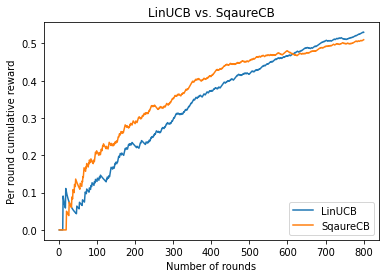

####################################### Experiment c #######################################

Tuning hyperparameter 'gamma'
SquareCB average reward for gamma 0: 0.10361681329423265
SquareCB average reward for gamma 250: 0.7704761904761904
SquareCB average reward for gamma 500: 0.7207729468599033
SquareCB average reward for gamma 750: 0.7211822660098522
SquareCB average reward for gamma 1000: 0.7940327237728585
SquareCB average reward for gamma 1250: 0.7936962750716332
SquareCB average reward for gamma 1500: 0.7940896091515729
SquareCB average reward for gamma 1750: 0.7944814462416746
SquareCB average reward for gamma 2000: 0.8001921229586936
SquareCB average reward for gamma 2250: 0.8038277511961722
SquareCB average reward for gamma 2500: 0.8044103547459253
SquareCB average reward for gamma 2750: 0.8026692087702574
SquareCB average reward for gamma 3000: 0.8019047619047619
SquareCB average reward for gamma 3250: 0.8019047619047619
SquareCB average reward for gamma 3500: 0.7982791586998

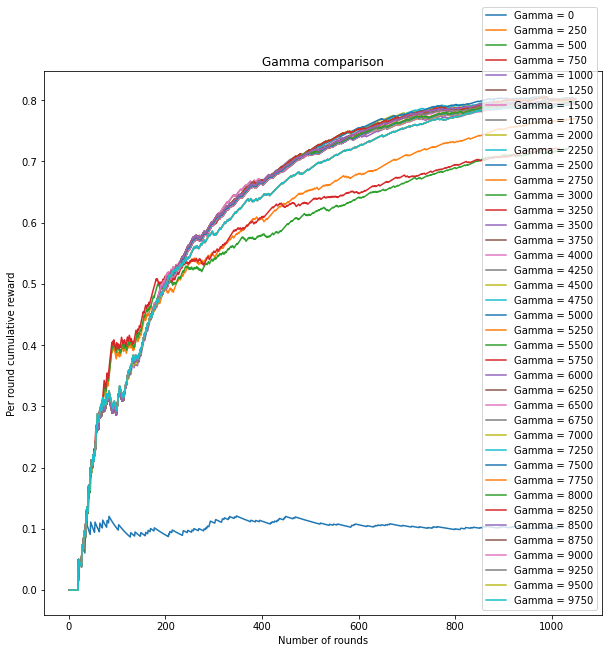


For gamma ~ 2500 the highest average reward is achieved. However starting at gamma ~ 1000 the mean rewards are significantly close.


In [15]:
# Use additional cells here for experimentation

print("####################################### Experiment b #######################################")
print("\nPlotting comparison of per-round cumulative reward for LinUCB and SquareCB")

mab = LinUCB(10, 10, 1.0, rng)
LinUCB_rewards, _ = offline_eval(mab, arms, rewards, contexts, 800)

n_rounds = 800
results = [{
    'type': 'LinUCB',
    'cum_rewards_per_round': np.cumsum(LinUCB_rewards)/np.arange(1, n_rounds + 1)
}, {
    'type': 'SqaureCB',
    'cum_rewards_per_round': np.cumsum(SquareCB_rewards)/np.arange(1, n_rounds + 1)
}]
    
bandit_comparison_plots(results, n_rounds)


print("####################################### Experiment c #######################################")
print("\nTuning hyperparameter 'gamma'")

def plot_gamma_comparison(results):
    """
    This function plots average cumulative reward per round for various gammas
    
    Parameter
    -----------------------
    results : list
        List of dictonaries where each dictionary has two keys: 'gamma', a gamma value and
        'cum_rewards_per_round', average cumulative reward per round for that gamma
    -----------------------
    """
    legends = []
    plt.figure(figsize=(10, 10))
    for i in results:
        plt.plot(range(1, i['cum_rewards_per_round'].size + 1), i['cum_rewards_per_round'])
        legends.append(f'Gamma = {i["gamma"]}')
    plt.title('Gamma comparison')
    plt.ylabel('Per round cumulative reward')
    plt.xlabel('Number of rounds')
    plt.legend(legends, loc='lower right')
    plt.show()
    
def tune_gamma(gammas):
    """
    This function take the search space of gamma as input and returns
    the best gamma and its corresponding average reward and also 
    average cumulative reward per round for every gamma
    
    Parameter
    ---------------------
    gammas : float ndarray
        Evenly-spaced values of gamma in a partiular interval
    ---------------------
    
    Returns
    ---------------------
    max_mean_reward : dict
        A dictonary with two keys: 'gamma', the best gamma in this particular search space 
        and the corresponding mean reward, 'mean_reward'
        
    results : list
        List of dictonaries where each dictionary has two keys: 'gamma', a gamma value and
        'cum_rewards_per_round', average cumulative reward per round
    ---------------------
    """
    results = []
    max_mean_reward = None

    for gamma in gammas:
        mab1 = SquareCB(10, 10, gamma, rng)
        SquareCB_rewards1, _ = offline_eval(mab1, arms, rewards, contexts)  # number of rounds is not passed to indicate exhaustive search over the entire history
        n_rounds = SquareCB_rewards1.size  # update number of rounds for this alpha with the returned reward array size
        mean_reward = np.mean(SquareCB_rewards1)
        
        # store the maximum mean reward and corresponding gamma until now 
        if max_mean_reward is None or mean_reward > max_mean_reward['mean_reward']:
            max_mean_reward = {'mean_reward': mean_reward, 'gamma': gamma}
            
        print(f'SquareCB average reward for gamma {gamma}:', mean_reward)
        cum_rewards = np.cumsum(SquareCB_rewards1)
        cum_rewards_per_round = cum_rewards/np.arange(1, n_rounds + 1)
        results.append({'cum_rewards_per_round': cum_rewards_per_round, 'gamma': gamma})
    
    plot_gamma_comparison(results)
    
    return max_mean_reward, results


max_mean_reward, history = tune_gamma(np.arange(0, 10000, 250))
print("\nFor gamma ~ 2500 the highest average reward is achieved. However starting at gamma ~ 1000 the mean rewards are significantly close.")